## Training the Model

<div class="alert alert-block alert-info">
<b>Training the GPT Model</b> 
 

From this section onwards we will be looking at <b> <font color="red"> Stage 2 </font> </b>

That is training the Model. 

Please take a look at the figure below.

</div>

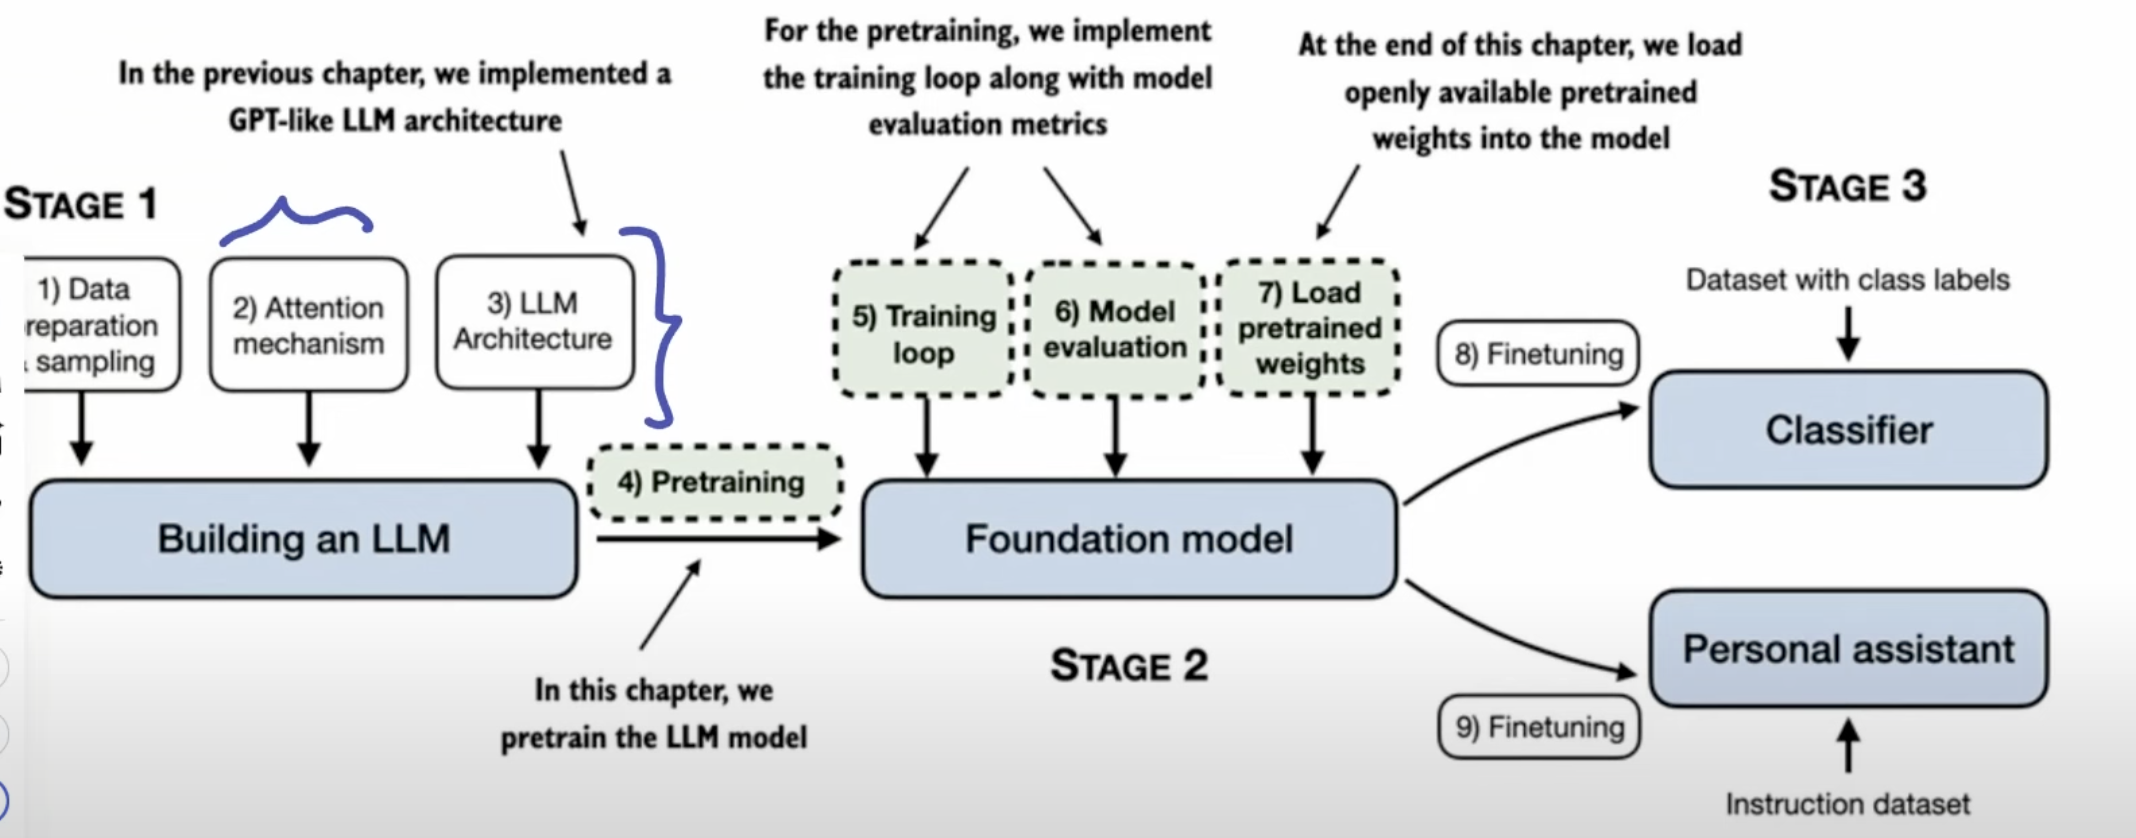

---

<div class="alert alert-block alert-info">
<b>Training the GPT Model</b> 
<p>
    
Last lecture we saw the  
1. Loaded the datasets 
2. Split them into training and validation sets
3. Loaded them using dataloaders
4. Create or organized the data in batches
5. validated that the splits are ok and no discrepancies
6. Ran the input throough Model to generate Logits
7. Calculated the Cross Entropy Loss


Now we shall training the LLM and apply backprogragation , so that all the weight parameters defined will be updated with each training iteration.

This way we make the model more intelligent and make them predict more acurate vocabulary based in sentence context

    
</p>
</div>

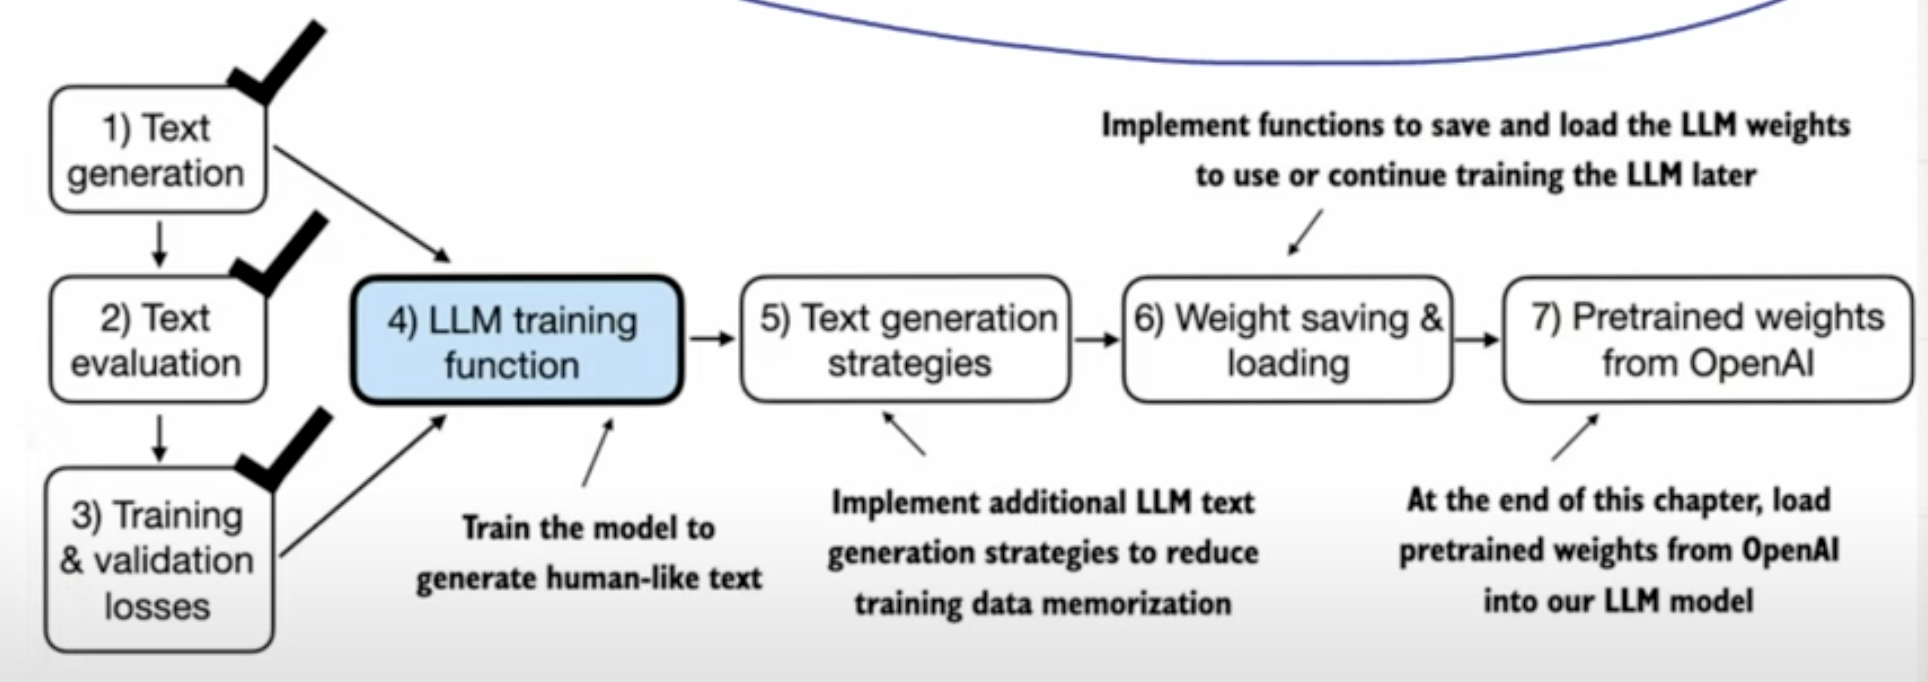

<div class="alert alert-block alert-info">
<b>Training the GPT Model</b> 
<p>
    
Basically like in NN , we create the datasets as Inputs and Labels for supervised learning

for ChatGPT we have already created this datasets in the formt if Input Datasets and Target Datasets.

In which we have defined Inputs as text tokens ,  and Target Datasets contains data from  next words in the input sequence

Example :-

Input = ['I' , 'Like' , 'to' , 'eat' , 'chocolate'].

Target = ['Like' , 'to' , 'eat' , 'chocolate' , 'and' , 'cold Drinks'] 

Meaning for Training LLM models , we have Input vector as our <font color="red">  Input Datasets </font>  and Target as <font color="red">  Labelled Datasets </font>

The reason being , GPT or any LLM is next word prediction alogrithm

</p>
</div>

---

## Lets start coding with real dataset

In [35]:
import torch
import torch.nn as nn
import numpy as np

<div class="alert alert-block alert-success">
<b> Chat GPT paramters</b> 
</div>

In [36]:
# Lets define the confoguration for GPT Model
# We planning to build the GPT Model with 124M parameters. This is the small GPT version

GPT_CONFIG_124M = {
  "vocab_size"     : 50257, # BPE encoding has the vocab size of 50257
  "context_length" : 256,  # number of token we can look at ones to predict new word
  "emb_dim"        : 768,   # The Toekn Embedding dimension
  "n_heads"        : 12,    # number of attention heads
  "n_layers"       : 12,    # Number of layers (Transformer blocks)
  "drop_rate"      : 0.1,   # Dropout Rate
  "qkv_bias"       : False  # Quert-Key-Value Bias
}

<div class="alert alert-block alert-success">
<b> Multihead attention</b> 
</div>

In [37]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out ,context_length , dropout , num_heads , qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads ==0) , f"d_out should be divisible by num_heads"

        self.d_out= d_out
        self.num_heads = num_heads
        self.head_dim= d_out // num_heads # check above for the explaination (10. Multi-head attention Part 2)
        
        # Here we have initialixed the Weight Matrices with larger dimensions already
        # This if to perform operations and then split to its respect heads based on value num_head
        # So in this example we decide d_out = 6 , hence with num_heads =2 , we will have 2 heads (causal attentions) with 3 dimension each
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        
        self.dropout= nn.Dropout(dropout)
        self.register_buffer("mask" ,
                             torch.triu(torch.ones(context_length , context_length),
                             diagonal=1))

    def forward(self,x):
        b,num_tokens,d_in = x.shape

        #print("Dimension of Weight Matrice before inputs operation" , self.W_value.weight.shape , "\n")
        # this gives us the 3 * 6 Weight matrices
        queries = self.W_key(x)
        keys    = self.W_query(x)
        values  = self.W_value(x)
        #print("Dimension of Weight Matrice after inputs operation:" , values.shape , "\n")
        #print("Values of Weight Matrice after inputs operation: \n" , values , "\n")

        # We implicitly split the matrix by adding a `num_heads` dimension
        # reshape the last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        # basically we just reshaping it per token , per head  (group by tokens)
        keys = keys.reshape(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.reshape(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.reshape(b, num_tokens, self.num_heads, self.head_dim)
        
        #print("Dimension of Weight Matrice after Reshape operation:" , values.shape, "\n") 
        #print("Values of Weight Matrice after Reshapr operation: \n" , values, "\n")

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        # This is required becuase we want to perform multiplication operation between data (token and dimesnion)
        # so we get the data that is tokens  and embedding at rthe end
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        #print("Dimension of Weight Matrice after Grouping by Head operation:" , values.shape, "\n") 
        #print("Values of Weight Matrice after Grouping by Head  operation: \n" , values, "\n")

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        # Now attn score dimension is (batch , head_num , tokens , head_dim)
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        #print("Dimension of Attention cores Matrice :" , attn_scores.shape, "\n") 
        #print("Values of Attention cores Matrice: \n" , attn_scores, "\n")

        
        # Original mask truncated to the number of tokens and converted to boolean
        # this is tghe edge case , if there are token less then context length (end of datasets)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        #print("Values of Masked Boolean Matrix: \n" , mask_bool, "\n")

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        #print("Values of Masked Attention cores Matrice: \n" , attn_scores, "\n")

        # Perform the normalization
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        # Perform the droput
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        #context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

<div class="alert alert-block alert-success">
<b> Layer Normalization</b> 
</div>

In [38]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps=1e-5
        self.scale=nn.Parameter(torch.ones(emb_dim))
        self.shift=nn.Parameter(torch.zeros(emb_dim))


    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1 , keepdim=True , unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var+self.eps)
        #print(norm_x)
        return self.scale * norm_x + self.shift

<div class="alert alert-block alert-success">
<b> Gelu Activation Function</b> 
</div>

In [39]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        activation = 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x,3))
        ))

        return activation

<div class="alert alert-block alert-success">
<b> Feed Forward Network</b> 
</div>

In [40]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # Define 1st layer with input and o/p size . Expansion
            GELU(),                                        # Define the Activation function
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # define the final layer . Contraction
        )

    def forward(self, x):
        return self.layers(x)

<div class="alert alert-block alert-success">
<b> Let put all this Layers to Transformer Block</b> 
</div>

<div class="alert alert-block alert-info">
<b>Keep This Block and all the Components in Mind</b> 
<p>   

We are working on build This block and stack all the components in the blocks 
   
![image.png](attachment:2e54891e-0a86-444e-a825-1507326998e7.png)



</p>
</div>

In [41]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)  # As seen in pic , this is LayerNorm1 (from bottom)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size] , This is Block 2
        x = self.drop_shortcut(x) # Then Dropout Block 3 (from bottom)
        x = x + shortcut  # Add the original input back (shortcut )

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x) 
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

<div class="alert alert-block alert-info">
<b>The GPT Block</b> 
<p>   

All of the components are stacked together to complete the GPT block

</p>
</div>

In [42]:
import torch
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"] , cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"] , cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = LayerNorm(cfg["emb_dim"])

        # this is the layer to convert the vector output to Logits vector 
        # of size batch * Context length * vocab_size
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size , seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx) # Embedd the tokesn to higher dimensional space
        pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device)) # get Pos Embedding
        x=tok_embeds + pos_embeds # Combine the Token Embeds with its position embeds
        x=self.drop_emb(x)   # Perform Droput 
        x=self.trf_blocks(x)
        x= self.final_norm(x)
        logits = self.out_head(x)
        return logits

---

# Let code .. We will load the larger dataset

In [43]:
# Read the dataset

def readFile(file_path:str)->str:
    try:
        with open(file_path , "r" , encoding="utf-8") as f:
            text=f.read()
            return text
    except FileNotFoundError:
         return "File not found."
    except Exception as e:
         return f"An error occurred: {str(e)}"
    

In [44]:
# check if the dataset is loaded correctly

file_path="data/the-verdict.txt"
text=readFile(file_path)
print(len(text))
print(text[:100])

20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [45]:
# Let us now encode the data using Bytpe Pair encoding algorithm 
# to get the tokens for charcacter text
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = tokenizer.encode(text)

print(f"Length of input dataset: {len(text)}")
print(f"Length of Tokens: {len(token_ids)}")

Length of input dataset: 20479
Length of Tokens: 5145


<div class="alert alert-block alert-info">
<b>Implementing the DataLoader:  </b> 
<p>   

`This is to build the dataset in batches and according to the configuration define`
`Basically we building INPUT and OUTPUT target pair`

</p>
</div>





In [46]:
from torch.utils.data import Dataset, DataLoader

# Class to create tensors from datasets
class GPTDatasetV1(Dataset):
    def __init__(self,txt,tokenizer, max_length , stride):
        self.inputs_ids =[]
        self.target_ids=[]

        token_ids = tokenizer.encode(txt,allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length

        for i in range(0,len(token_ids)-max_length,stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]

            self.inputs_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.inputs_ids)

    def __getitem__(self,idx):
        return self.inputs_ids[idx],self.target_ids[idx]

In [47]:
# Create the dataloader

def create_dataloader_v1(txt , batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")
    
    # Create dataset
    dataset = GPTDatasetV1(txt,tokenizer,max_length,stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers        
    )

    return dataloader

<div class="alert alert-block alert-info">
<b>Lets split the data into Train and Test </b> 
<p>   



</p>
</div>

In [48]:
train_data_ratio = 0.90  # 90% of data will be training data
split_idx=int(train_data_ratio*len(text))
train_data=text[:18431]
val_data=text[18431:]

<div class="alert alert-block alert-info">
<b>Create the datasets for Train and Validation Data </b> 
<p>   



</p>
</div>

In [49]:
torch.manual_seed(123)

train_loader=create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
    
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

<div class="alert alert-block alert-info">
<b>Lets Validate if we have split done is correct </b> 
<p>   



</p>
</div>

In [50]:
# Lets check the number of batches in Training and Validation

print("Number of Batches in Train:",len(train_loader))
print("Number of Batches in Validation:",len(val_loader))

Number of Batches in Train: 9
Number of Batches in Validation: 1


In [51]:
# Number of Total Tokens Check in train and validation splits

train_total=0
val_total=0
for batch_idx, (inputs, targets) in enumerate(train_loader):
         temp=(inputs.shape[1]*inputs.shape[0])
         train_total=train_total+temp

for batch_idx, (inputs, targets) in enumerate(val_loader):
         temp=(inputs.shape[1]*inputs.shape[0])
         val_total=val_total+temp

print("Total Token:",train_total+val_total)

Total Token: 5120


In [52]:
# Traing and validation batch and its size
print("Training Set:\n")
for x,y in train_loader:
    print(x.shape, y.shape)

print("\n")

print("Validation Set:\n")
for x,y in val_loader:
    print(x.shape, y.shape)

Training Set:

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


Validation Set:

torch.Size([2, 256]) torch.Size([2, 256])


---

<div class="alert alert-block alert-info">
<b>Let calculate the Training and Validation Loss </b> 
<p>   

Now we have performed all the pre-requities :
1. Loaded the datasets
2. Split them into training and validation sets
3. Loaded them using dataloaders
4. Create or organized the data in batches
5. validated that the splits are ok and no discrepancies

Next we will start on caluclating the Loss for training and validation.
This we do by training the model

</p>
</div>

In [53]:
torch.manual_seed(123)
model=GPTModel(GPT_CONFIG_124M)

#Disable the Dropout during indeference. This sets the model to evaluation mode. 
#This is important because it disables certain features like dropout, which are only used during training to prevent overfitting. 
#In evaluation mode, the model behaves deterministically, which is essential for generating consistent and predictable outputs.
model.eval(); 

<div class="alert alert-block alert-success">

Next, we implement a utility function to calculate the cross-entropy loss of a given batch.

In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader.
</div>

In [54]:
# This method gets the batch.
# Pass that batch through our GPT model.
# Calculate the logits
# Then calculate the Loss using entropy and flattening the logits and target.
# The target tokens then lookup into the logits to get the probas score to calculate the loss

def calc_loss_per_batch(input_batch , target_batch , model , device):
    input_batch , target_batch = input_batch.to(device) , target_batch.to(device)
    logits = model(input_batch).to(device)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1) ,target_batch.flatten())
    return loss
    

In [55]:
def calc_loss_loader(dataloader , model, device , num_batches=None):
    total_loss=0
    if (len(dataloader)==0):  # check the # of batches in the split (train or validation)
        return float("nan")   # Return nan if nothing is present . Meaning no batches
    else:
        num_batches=len(dataloader) # assign the # of batches valie in train/validation to variable

       # Loop through the dataloader (test/val) get inout and target batch , pass to calc_loss
    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            loss = calc_loss_per_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches # calculate the average of loss

In [59]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

# The data and the Model has to be on the same devicer. Or else it will throw runtime 
# Exception . You can try this by changing below to
# model.to("cpu") 

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

Using mps device.


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [60]:
torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987869474622938
Validation loss: 10.98089599609375


---

# Training Loop for the LLM

<div class="alert alert-block alert-success">
Below are the STeps we shall be carrying out to training the LLM

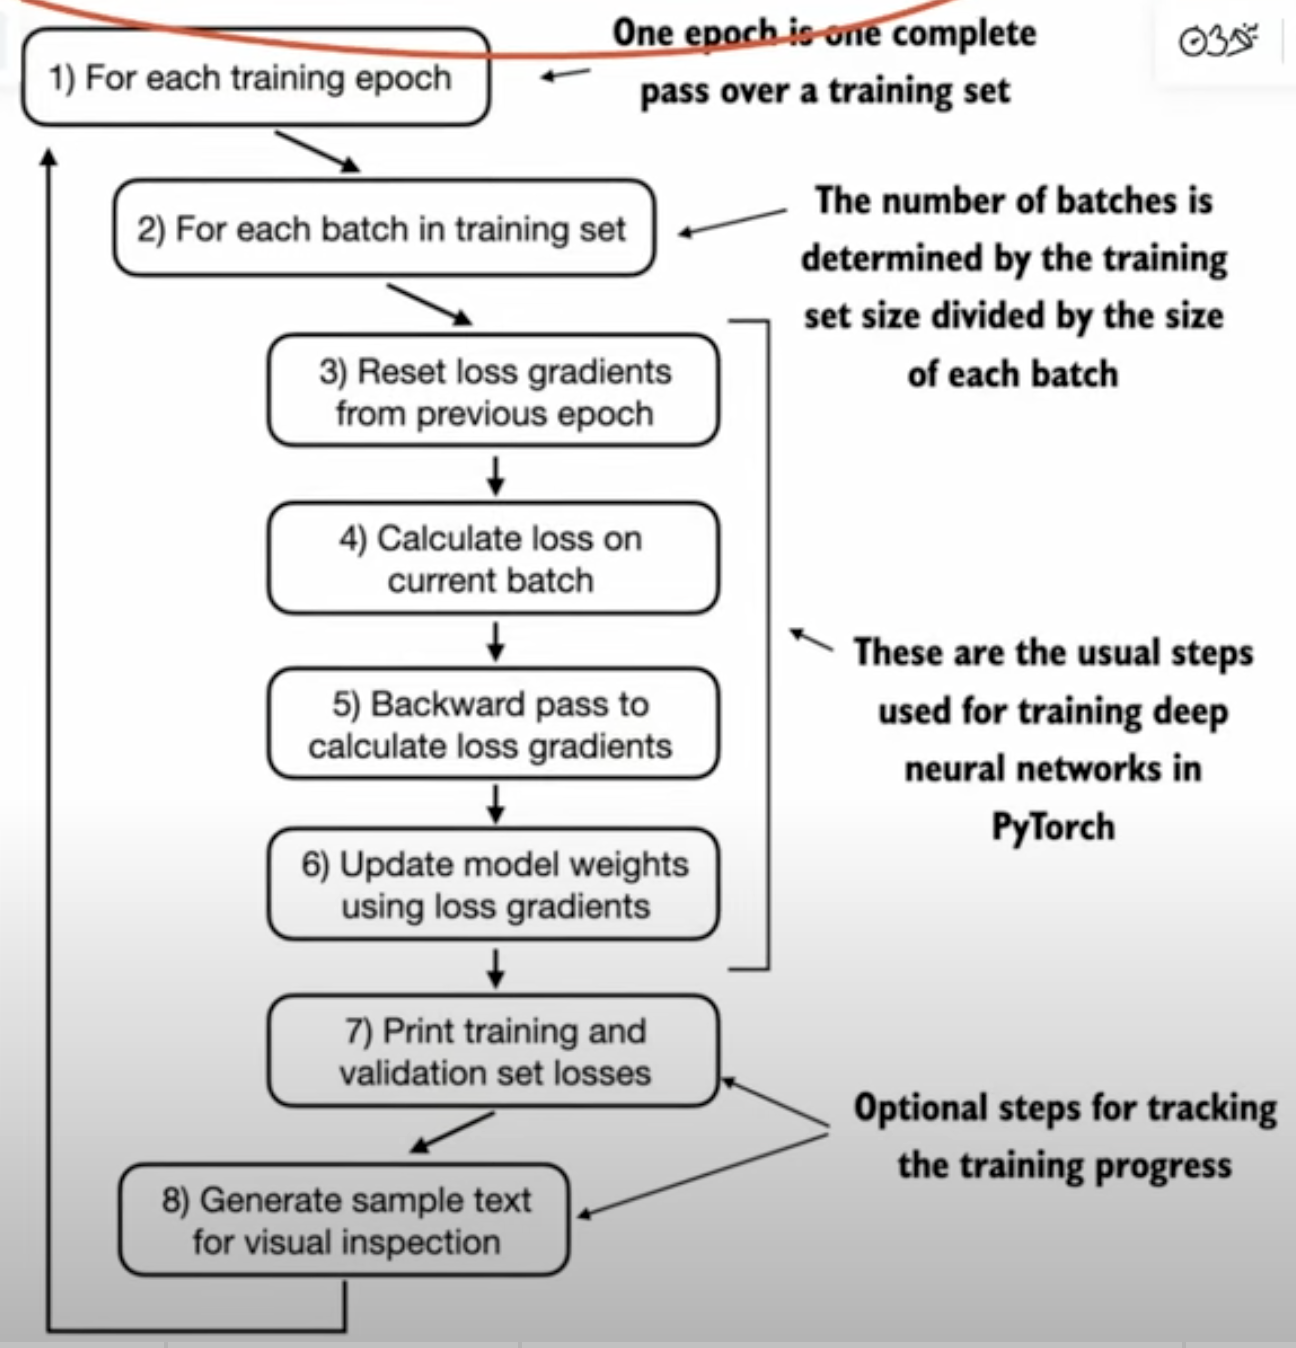

</div>

In [1]:
def evaluate_model(model , train_loader , val_loader ,device ,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader , model , device,num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader , model , device,num_batches=eval_iter)
        model.train()
        return train_loss , val_loss

In [128]:
def generate_text_simple(model, idx, max_new_tokens, context_size , device):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])
    
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        model.to(device)
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond.to(device)) ### batch, n_tokens, vocab_size
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx.to(device), idx_next.to(device)), dim=1)  # (batch, n_tokens+1)

    return idx

In [129]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"



token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
    device=device
)

In [132]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size,device=device
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [126]:
# Training Loop 

def train_model_simple(model , train_loader , val_loader , optimizer , device , num_epochs,
                       eval_freq , eval_iter , start_input_stream, tokenizer):

    # Initialize lists to track losses and tokens seen during training
    train_losses , val_losses , track_tokens_seen = [] , [] ,[]
    token_seen , global_step= 0, -1

    # Define mail training loop
    # This loop goes through entire dataset

    for epoch in range(num_epochs):
        print("In Epock")
        model.train()  # Set the model to training mode

        for input_batch , target_batch in train_loader:
            optimizer.zero_grad() #Reset the loss gradient from previous batch iteration
            loss = calc_loss_per_batch(input_batch, target_batch , model , device)
            loss.backward()  # Calcuate loss gradient
            optimizer.step() #update model weights using loss gradient
            token_seen+= input_batch.numel()
            global_step+= 1


            if global_step % eval_freq == 0:
                train_loss , val_loss = evaluate_model(model , train_loader , 
                                                       val_loader ,device ,eval_iter)
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(token_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

                # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_input_stream 
        )

    return train_losses, val_losses, track_tokens_seen

In [140]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_input_stream="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In Epock
Ep 1 (Step 000000): Train loss 10.937, Val loss 10.938
Ep 1 (Step 000005): Train loss 10.678, Val loss 10.730
Every effort moves you renting Tsuk motivatedم Superman wallpaper universal 44 millenn,, TT remember BASE twisting voidflash hoped         showMondayp Dele cheochemistry grocery stakeholdersIngredients   Whats had electorate theological Mysteries ASP millionaires unlocksMayor →ichever badges
In Epock
Ep 2 (Step 000010): Train loss 10.423, Val loss 10.523
Ep 2 (Step 000015): Train loss 10.174, Val loss 10.312
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
In Epock
Ep 3 (Step 000020): Train loss 9.937, Val loss 10.104
Ep 3 (Step 000025): Train loss 9.732, Val loss 9.918
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
In Epock
Ep 4 (Step 000030): Train loss 9.561, Val loss 9.757
Ep 4 (Step 000035): Train loss 9.420, Val loss 9.622
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
In Epock
Ep 5 (Step

<div class="alert alert-block alert-info">

As we can see, based on the results printed during the training, the training loss improves
drastically, starting with a value of 9.781 and converging to 0.391. 

The language skills of
the model have improved quite a lot. In the beginning, the model is only able to append
commas to the start context ("Every effort moves you,,,,,,,,,,,,") or repeat the
word "and". 

At the end of the training, it can generate grammatically correct text.
    
</div>

<div class="alert alert-block alert-info">

Similar to the training set loss, we can see that the validation loss starts high (9.856)
and decreases during the training. 

However, it never becomes as small as the training set
loss and remains at 6.372 after the 10th epoch.
    
</div>

<div class="alert alert-block alert-success">

Let's create a simple plot that shows the training and validation set losses side by side
</div>

In [136]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

ModuleNotFoundError: No module named 'matplotlib'